# 4_Plume_Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import colormaps

from plume_learn.plume_utils.viz import label_violinplot, set_labels, set_cbar
from m3util.viz.layout import layout_fig, layout_subfigures_inches
from m3util.viz.text import labelfigs
from sro_sto_plume.modify_df import modify_df
from sro_sto_plume.packed_plot_functions import plot_plume_inhomogeneity_area, plot_plume_inhomogeneity_velocity, plot_combined_plume_inhomogeneity

colors = colormaps.get_cmap('tab10').colors[:6]

from m3util.viz.printing import printer
printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)

/tmp/ipykernel_1216808/3402512655.py:22: DeprecationWarning: The 'printer' class/function has been renamed to 'Printer'. Please update your code.
  printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)


## 1. Load Plume data

### 1.1 load experiment conditions

In [2]:
sample_names = ['G5', 'C-G6']
sample_ids = ['YG069', 'YG063']
metric_names = ['Area (a.u.)', 'Velocity (m/s)']
custom_palette = {'G5': colors[-2], 'C-G6': colors[-1]}
output_root = '../data/Plumes/plume_metrics/'

### 1.2 load metrics for every plume frame

In [3]:
df_frame_metrics = []
for id, sample_name in zip(sample_ids, sample_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

/tmp/ipykernel_1216808/167744838.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_1216808/167744838.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Sample Name,Sample ID
0,0,0.0,0.000000,0.000000,0.0,200,G5,YG069
1,0,0.5,0.006847,13694.524496,464.0,200,G5,YG069
2,0,1.0,0.015406,17118.155620,3731.0,200,G5,YG069
3,0,1.5,0.022254,13694.524496,9269.0,200,G5,YG069
4,0,2.0,0.025677,6847.262248,13511.0,200,G5,YG069
...,...,...,...,...,...,...,...,...
84987,377,61.5,0.032836,0.000000,0.0,200,C-G6,YG063
84988,377,62.0,0.032836,0.000000,0.0,200,C-G6,YG063
84989,377,62.5,0.032836,0.000000,0.0,200,C-G6,YG063
84990,377,63.0,0.032836,0.000000,0.0,200,C-G6,YG063


### 1.3 Calculate plume level metrics

In [4]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.028) & (df_frame_metrics['Distance (m)'] <= 0.029)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

# df_sample
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0.5) & (df_frame_metrics['Time (µs)'] < 7)] 
df_sample = df_sample[df_sample['Sample Name'].isin(sample_names)]
df_sample = df_sample.dropna()  # Remove all rows with NaN values

## 2. Plume Dynamics Analysis with target spatial inhomogeneity

### 2.1 Plume Max Statistics

../figures/Figure6-Spatial_inhomogeneity_combined.png
../figures/Figure6-Spatial_inhomogeneity_combined.svg
../figures/Figure6-Spatial_inhomogeneity_combined.tif


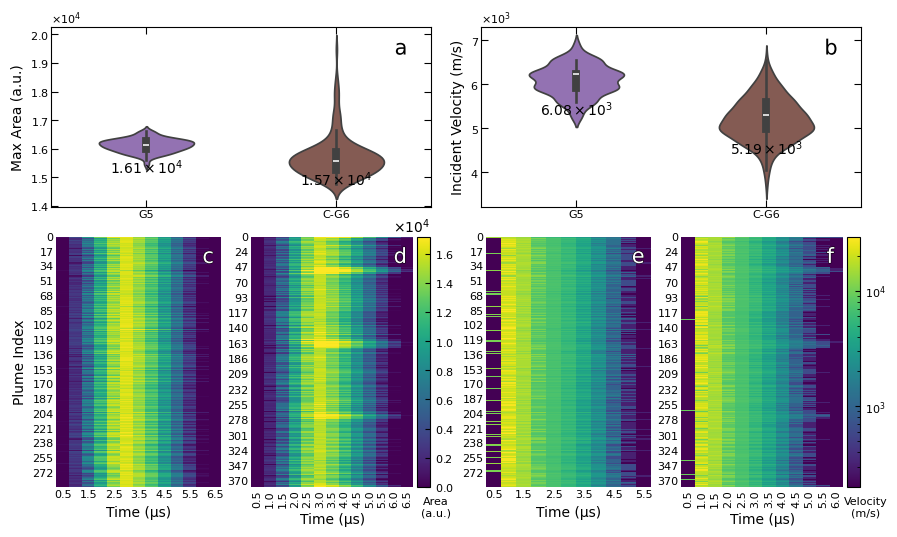

In [9]:
fig, axes_dict = plot_combined_plume_inhomogeneity(df_plume_metrics, df_sample, sample_names, custom_palette)
# plt.savefig('../figures/6-Spatial_inhomogeneity_area.svg', dpi=600, bbox_inches='tight', transparent=True)
printing.savefig(fig, 'Figure6-Spatial_inhomogeneity_combined')
plt.show()

In [6]:
# fig, axes_dict = plot_combined_plume_inhomogeneity(df_plume_metrics, df_sample, sample_names, custom_palette, label=False)
# plt.savefig('../figures/6-Spatial_inhomogeneity_area.svg', dpi=600, bbox_inches='tight', transparent=True)
# printing.savefig(fig, '6-Spatial_inhomogeneity_combined-no_marks')
# plt.show()